# Bayesian Testing

Here I'd like to demonstrate how a hypothesis test may be conducted using Bayesian methodology as opposed to the typically used frequentist approaches.
We'll start by Importing Libraries...

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In the example I am using we'll conduct an A/B test using click data from two sites. At the end of the analysis, we hope to conclude which one site performs better in terms of click-through rate and a recommended action to take.

First, let's visualize our understanding of the CTR as the data streams in for just site A. In a bayesian test, the very first prior is the baseline (uniform) probability distribution before we consider any observation.
So before we get any data, we will say that every probability of 0 (no click) to 1 (click) is equally likely.
We would like to plot our distribution.

In [2]:
A = np.loadtxt('data/siteA.txt')
B = np.loadtxt('data/siteB.txt')

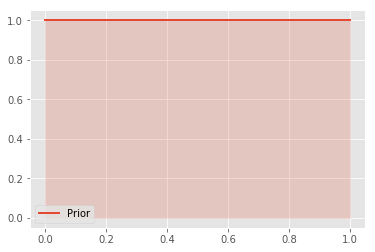

In [3]:
x = np.arange(0, 1.01, 0.01)
y = stats.uniform(0, 1).pdf(x)
ax = plt.gca()

def plot_with_fill(ax, x, y, label):
    lines = ax.plot(x, y, label=label, lw=2)
    ax.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_c())

plot_with_fill(ax,x,y,'Prior')
plt.legend();

Next, we'll consider the data of siteA for the first 50 views, drawing a plot of the posterior
after gathering this data. We should add the alpha parameter the number of conversions
we've gotten. To the beta parameter, add the number of non-conversions we've gotten.

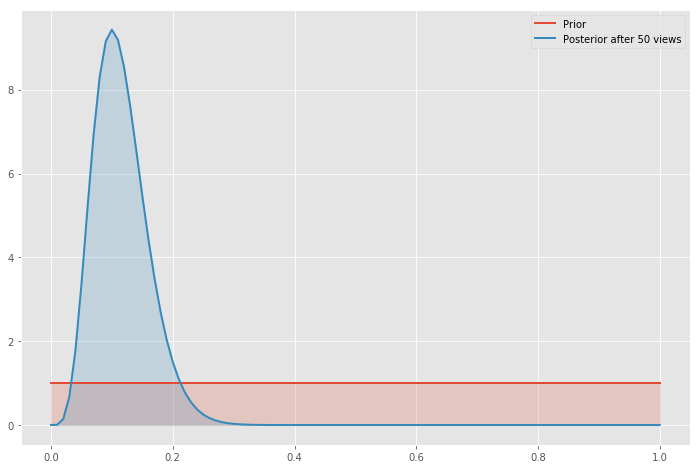

In [4]:
plt.figure(figsize=(12,8))
alpha = A[:50].sum()+1
beta = 50 - alpha + 2

pA = stats.beta(1,1).pdf(x)
ax = plt.gca()
plot_with_fill(ax,x,y,'Prior')

pA = stats.beta(alpha,beta).pdf(x)
plot_with_fill(ax,x,pA,'Posterior after 50 views')

plt.legend();

After 50 views, we're starting to hone in on our prediction of pA. We'll overlay on
the same graph the posterior after 50 views, 100 views, 200 views, 400 views and finally all 800 views.
We should see as time progresses that we get more certain of the true value of pA.

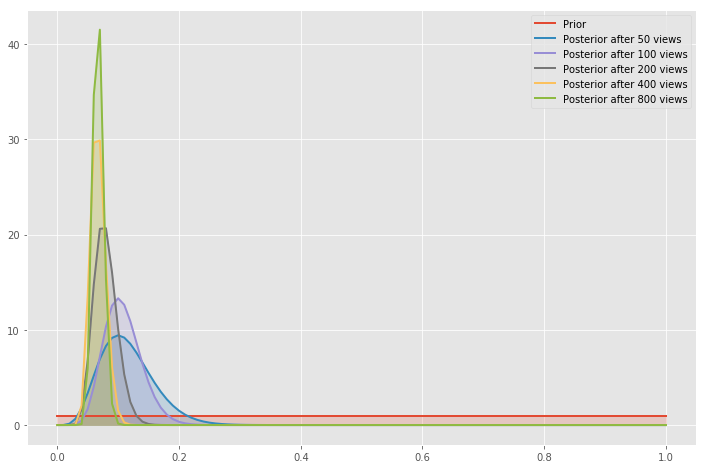

In [5]:
plt.figure(figsize=(12,8))
views_sampling = [50,100,200,400,800]

pA = stats.beta(1,1).pdf(x)
ax = plt.gca()
plot_with_fill(ax,x,y,'Prior')

for views in views_sampling:
    alpha = A[:views].sum()+1
    beta = views - alpha + 2

    pA = stats.beta(alpha,beta).pdf(x)
    ax = plt.gca()

    plot_with_fill(ax,x,pA,'Posterior after '+str(views)+' views')

plt.legend();

Now we should understand how we're using the beta distribution to represent
the distribution of the possible values of pA. Make a graph that has the final distributions
for both pA and pB after all 800 views

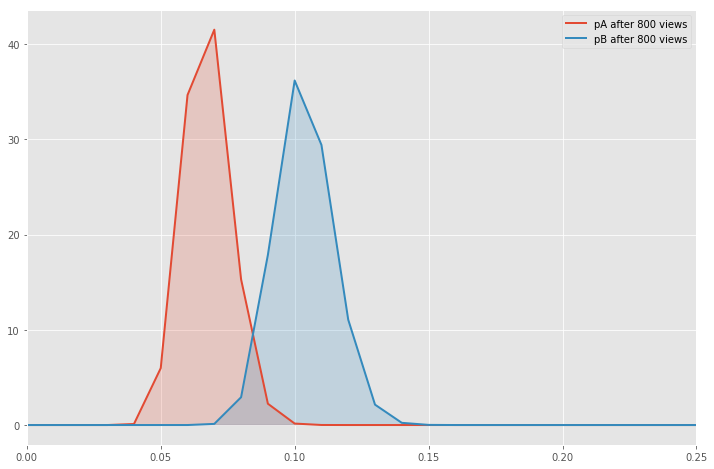

In [6]:
plt.figure(figsize=(12,8))
alpha = A[:800].sum()+1
beta = 800 - alpha + 2

pA = stats.beta(alpha,beta).pdf(x)
ax = plt.gca()
plot_with_fill(ax,x,pA,'pA after 800 views')

alpha = B[:800].sum()+1
beta = 800 - alpha + 2

pB = stats.beta(alpha,beta).pdf(x)
plot_with_fill(ax,x,pB,'pB after 800 views')

ax.set_xlim(0,0.25)

plt.legend();

We now want to determine, given these distributions, what is the probability
that site B is better than site A. We do this with a simulation.
Draw 10,000 points from site A's beta distribution and 10,000 points
from site B's distribution. We can either stats.beta().rvs() or np.random.beta() for this.

In [7]:
sample_size = 10000
alph_A = np.sum(A)+1
beta_A = len(A)+2 - alph_A
alph_B = np.sum(B)+1
beta_B = len(A)+2 - alph_B

A_sample = np.random.beta(alph_A, beta_A, size=sample_size)
B_sample = np.random.beta(alph_B, beta_B, size=sample_size)

print("Number of times that what we drew from site B's distribution is larger than what we drew from site A's distribution: {:2.4}".\
        format(np.sum(B_sample>A_sample)/sample_size))

Number of times that what we drew from site B's distribution is larger than what we drew from site A's distribution: 0.9958


An X% credible interval in a posterior distribution is analogous to a
frequentist analysis's confidence intervals. One method of determining a
credible interval is the highest density interval (HDI), which is the most dense
interval of a posterior distribution containing X% of its mass. Another method is the
equal-tailed interval, which is the interval containing X% of the posterior distribution's
mass where the probability of being below the interval is as likely as being above it.

Determine the 95-percent equal-tailed interval

In [8]:
lower = stats.beta(alph_A,beta_A).ppf(.025)
upper = stats.beta(alph_A,beta_A).ppf(.975)

print("95% credible interval: [{}, {}]".format(lower,upper))

95% credible interval: [0.05104704398553145, 0.08565814425314011]


A great thing about Bayesian A/B testing is that we can also answer the question: what is the probability that site B is 2 percentage points better than site A?

 * Here, instead of needing B > A, we need B > A + 0.02.
 * We should determine that we need more data to say this with confidence.
 * Note, when you compare B > A you can calculate a single probability that this occurs in the simulation, but you can also do something richer, like calculate the entire distribution of B - A. Plot a histogram of this quantity. Try B-A-.02. What distribution do the shape of these histograms suggest? Why? What shape does it take on if you only use one observation of site_b's data? Is this a problem?

In [9]:
prob = (B_sample > A_sample + 0.02).mean() * 100
print(
    'There is a {:.2f}% probability that Site B is 2% better than Site A\n'.format(prob))

There is a 87.85% probability that Site B is 2% better than Site A



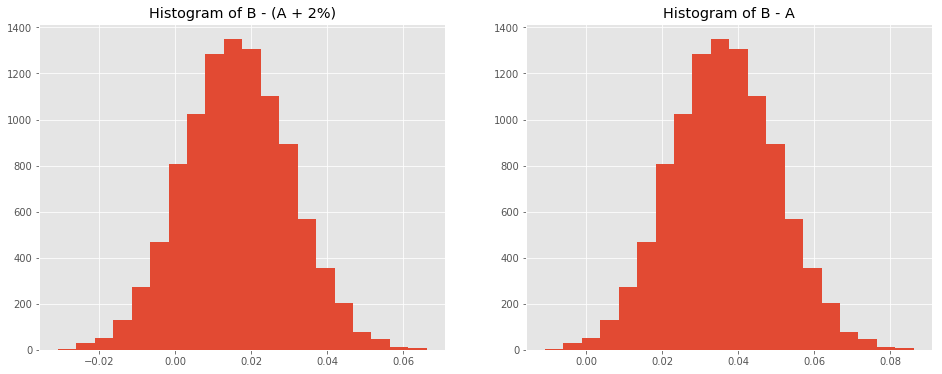

In [10]:
# Now let's take a look at the histogram of the difference b/w B and A + 2%
fig, axs = plt.subplots(1,2,figsize=(16,6))

for i, ax in enumerate(axs.flatten()):
    if i == 0: 
        site_diff = B_sample - (A_sample + 0.02) 
        ax.hist(site_diff, bins=20)
        ax.set_title('Histogram of B - (A + 2%)')
    else: 
        site_diff = B_sample - A_sample
        ax.hist(site_diff, bins=20)
        ax.set_title('Histogram of B - A');
    

>Shape suggests a normal distribution

For a sanity check, let's see that we get similar results using the frequentist approach. Which could you answer with a frequentist approach?

$ H_0 $ = There is no difference in the CTR between site A and site B

$ H_A $ = Site B has a higher CTR than site A

Note that we divide the p-value returned by Scipy by 2 because by default it returns a p-value for a 2-tailed test and we are running a one-tail test

In [11]:
#Looking first at the Alternate Hypothesis that Site B has a higher CTR than site A
t, p = stats.ttest_ind(A, B)
if p/2 < 0.05:
    print("We can reject null hypothesis. P-value: {}\n".format(p/2))
else:
    print("We cannot reject null hypothesis. P-value: {}\n".format(p/2))

We can reject null hypothesis. P-value: 0.004538672628645521



In [12]:
#Looking next at the Alternate Hypothesis that Site B has a higher CTR than site A by 2%
t, p = stats.ttest_ind(A+0.02, B)
if p/2 < 0.05:
    print("We can reject null hypothesis. P-value: {}\n".format(p/2))
else:
    print("We cannot reject null hypothesis. P-value: {}\n".format(p/2))

We cannot reject null hypothesis. P-value: 0.12087882819863756



It's important to understand the business impact. Imagine that your company is debating whether to switch to site B from site A. 
Assume the following:

 * the average click on site A yields \$1.00 USD in profit
 * the average click on site B yields \$1.05 USD in profit
 
Should your company invest in switching to site B?

In [13]:
def expected_profit_difference(hits, expect_a, expect_b):
    ''' Returns the expected profit from switching from A to B

    Parameters
    -----------
    hits : int number of clicks you expect your site to recieve
    expect_a : Expected CTR value of Site A
    expect_b : Expected CTR value of Site B

    Returns
    --------
    profit : float
    '''
    return expect_b * 1.05 * hits - expect_a * 1.00 * hits

In [14]:
# Let's find the expected CTR of each site
expect_a = A_sample.mean()
expect_b = B_sample.mean()

In [15]:
# Let's look at a wide range of possible hits
hits = [10000 * 10**p for p in range(6)]
diffs = [expected_profit_difference(hit, expect_a, expect_b) for hit in hits]
for hit, diff in zip(hits, diffs):
    print("Expected difference of ${:.2f} for {} hits".format(diff, hit))

Expected difference of $414.08 for 10000 hits
Expected difference of $4140.77 for 100000 hits
Expected difference of $41407.65 for 1000000 hits
Expected difference of $414076.55 for 10000000 hits
Expected difference of $4140765.45 for 100000000 hits
Expected difference of $41407654.55 for 1000000000 hits


>As you can see, it depends on the cost of switching over to site B and how much traffic your site is getting (i.e. how many hits you can expect your site to yield. For instance, if the expected total cost of switching is less than \$40k and you expect your site to get over a million hits, it's worth switching as the expected difference in profit is greater. You may also need to consider variable costs (i.e. if the new site requires more regular maintenance, licences etc.) and the time horizon you need to show a return for.